### Install/import packaages

In [58]:
%pip install -q tensorflow
%pip install -q keras
%pip install -q keras.utils
%pip install -q openpyxl
%pip install -q shap
%pip install -q ipywidgets
%pip install -q xgboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [85]:
import pandas as pd
pd.set_option('display.max_colwidth', 160)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay
from sklearn.svm import SVC

from keras import Sequential
from keras.api.layers import Dense
from keras.api.utils import to_categorical


### Load Data in Dataframe

In [60]:
# Load the dataset
df = pd.read_excel('dataset.xlsx')

# Display the dataset to understand its structure and the extent of missing data
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  925 non-null    int64  
 1   var1    925 non-null    float64
 2   var2    925 non-null    float64
 3   var3    925 non-null    object 
 4   var4    325 non-null    float64
 5   var5    925 non-null    float64
 6   var6    925 non-null    object 
 7   var7    925 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 57.9+ KB
None
target      0
var1        0
var2        0
var3        0
var4      600
var5        0
var6        0
var7        0
dtype: int64


### Data Preprocessing

#### var7 data fixes

In [61]:
# Convert datetime to numeric (timestamp)
df['var7'] = pd.to_datetime(df['var7'], errors='coerce')
df['var7'] = df['var7'].astype('int64') / 10**9  # Convert to seconds since epoch

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  925 non-null    int64  
 1   var1    925 non-null    float64
 2   var2    925 non-null    float64
 3   var3    925 non-null    object 
 4   var4    325 non-null    float64
 5   var5    925 non-null    float64
 6   var6    925 non-null    object 
 7   var7    925 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 57.9+ KB


#### var4 prediction using K-NN

In [62]:
# Encode categorical variables
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Scale the data before imputing
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Use KNNImputer to fill missing values in var4
imputer = KNNImputer(n_neighbors=5)
df.iloc[:, :] = imputer.fit_transform(df)

### Prepare the data for classification models

In [63]:
# Split the data into features and target
X = df.drop('target', axis=1)
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (740, 7)
y_train: (740,)
X_test: (185, 7)
y_test: (185,)


### Classifiers

#### Random Forests

In [65]:
# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy of Random Forests: {accuracy}")
print("Classification Report:")
print(class_report)


Accuracy of Random Forests: 0.9621621621621622
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        97
           1       0.96      0.97      0.96        88

    accuracy                           0.96       185
   macro avg       0.96      0.96      0.96       185
weighted avg       0.96      0.96      0.96       185



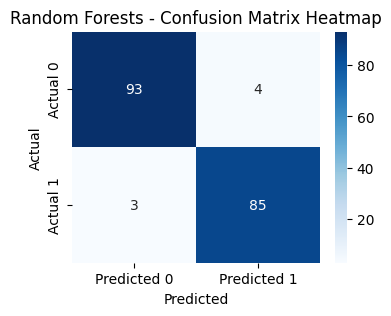

In [66]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forests - Confusion Matrix Heatmap')
plt.show()

#### Logistic Regression

In [67]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Logistic Regression Classifier
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy of Logistic Regression: {accuracy}")
print("Classification Report:")
print(class_report)

Accuracy of Logistic Regression: 0.9513513513513514
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95        97
           1       0.94      0.95      0.95        88

    accuracy                           0.95       185
   macro avg       0.95      0.95      0.95       185
weighted avg       0.95      0.95      0.95       185



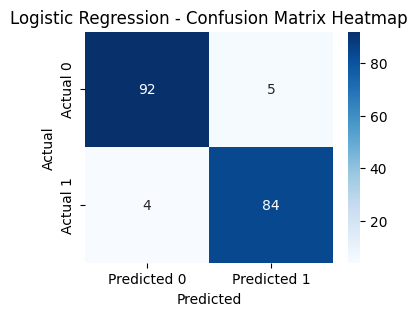

In [68]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression - Confusion Matrix Heatmap')
plt.show()

#### Decision Trees

In [69]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy of Decision Trees: {accuracy}")
print("Classification Report:")
print(class_report)

Accuracy of Decision Trees: 0.9405405405405406
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94        97
           1       0.93      0.94      0.94        88

    accuracy                           0.94       185
   macro avg       0.94      0.94      0.94       185
weighted avg       0.94      0.94      0.94       185



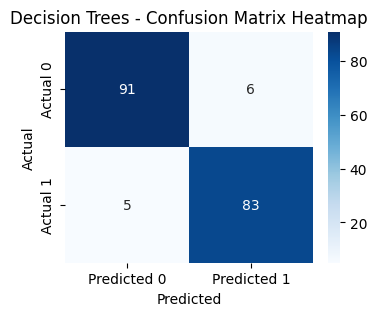

In [70]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Trees - Confusion Matrix Heatmap')
plt.show()

#### ANN

In [71]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert target variable to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Build the neural network
sequentialModel = Sequential()
sequentialModel.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
sequentialModel.add(Dense(32, activation='relu'))
sequentialModel.add(Dense(2, activation='softmax'))

# Compile the model
sequentialModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
sequentialModel.fit(X_train, y_train, epochs=50, batch_size=10, verbose=1)

# Evaluate the model
loss, accuracy = sequentialModel.evaluate(X_test, y_test, verbose=0)
y_pred = np.argmax(sequentialModel.predict(X_test), axis=1)
y_test_class = np.argmax(y_test, axis=1)

class_report = classification_report(y_test_class, y_pred)

print(f"Accuracy of ANN: {accuracy}")
print("Classification Report:")
print(class_report)

Epoch 1/50


C:\Users\nares\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step - accuracy: 0.8726 - loss: 0.4074
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.9493 - loss: 0.1476
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9696 - loss: 0.1026
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.9697 - loss: 0.0997
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - accuracy: 0.9702 - loss: 0.0998
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.9739 - loss: 0.0795
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.9659 - loss: 0.1093
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9645 - loss: 0.1027
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.9723 - loss: 0.1058
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9693 - loss: 0.0820  
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9781 - loss: 0.0846
Epoch 12/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.96

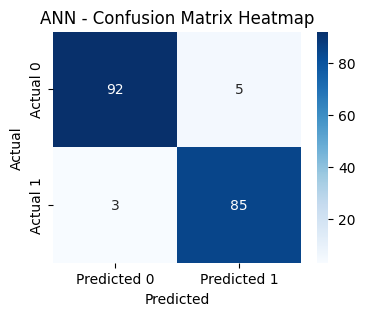

In [72]:
# Confusion matrix
cm = confusion_matrix(y_test_class, y_pred)

# Plot the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ANN - Confusion Matrix Heatmap')
plt.show()

#### SVM

In [88]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create an SVM classifier with a linear kernel
svm_classifier = SVC(kernel='linear')

# Train the classifier on the training data
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [89]:
# Make predictions on the test data
y_pred = svm_classifier.predict(X_test)

# Evaluate the performance of the classifier
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[134   4]
 [  8 132]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       138
           1       0.97      0.94      0.96       140

    accuracy                           0.96       278
   macro avg       0.96      0.96      0.96       278
weighted avg       0.96      0.96      0.96       278


Accuracy Score:
0.9568345323741008


In [95]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# After finding the best parameters
param_grid = {
    'C': [1], 
    'gamma': [1], 
    'kernel': ['rbf']
}

In [96]:
# Create a GridSearchCV object
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate the best model on the test data
y_pred_best = best_model.predict(X_test)

print("\nBest Model Classification Report:")
print(classification_report(y_test, y_pred_best))

print("\nBest Model Accuracy Score:")
print(accuracy_score(y_test, y_pred_best))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
Best Parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

Best Model Confusion Matrix:
[[127  11]
 [  5 135]]

Best Model Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       138
           1       0.92      0.96      0.94       140

    accuracy                           0.94       278
   macro avg       0.94      0.94      0.94       278
weighted avg       0.94      0.94      0.94       278


Best Model Accuracy Score:
0.9424460431654677


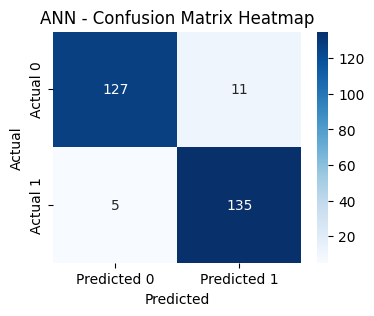

In [97]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

# Plot the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ANN - Confusion Matrix Heatmap')
plt.show()

#### Accuracy

| Classifier                                                    | Accuracy              |
| ------------------------------------------------------------- | --------------------: |
| Accuracy of Random Forests                                    | 0.9621621621621622    |
| Accuracy of ANN			                                    | 0.9621621370315552    |
| Accuracy of Logistic Regression	                            | 0.9513513513513514    |
| Accuracy of SVM                                               | 0.9424460431654677    |
| Accuracy of Decision Trees	                                | 0.9405405405405406    |

We will use Random Forests as our classifier to fine-tune.


### Fine-tuning Random Forest

#### Cross validation

In [73]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# This is after the hyperparameter fine-tuning
param_grid = {
    'bootstrap': [False], 
    'max_depth': [10],
    'max_features': ['sqrt'],
    'min_samples_leaf': [2],
    'min_samples_split': [2], 
    'n_estimators': [300]
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid,
                            cv=3, n_jobs=4, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=4,
             param_grid={'bootstrap': [False], 'max_depth': [10],
                         'max_features': ['sqrt'], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             scoring='accuracy', verbose=2)

In [74]:
# Evaluate the best model
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

print(f'Train Accuracy: {grid_search.score(X_train, y_train):.3f}')
print(f'Test Accuracy: {grid_search.score(X_test, y_test):.3f}')

Best Parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy on Test Set: 0.9621621621621622
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96        97
           1       0.96      0.97      0.96        88

   micro avg       0.96      0.96      0.96       185
   macro avg       0.96      0.96      0.96       185
weighted avg       0.96      0.96      0.96       185
 samples avg       0.96      0.96      0.96       185

Train Accuracy: 0.996
Test Accuracy: 0.962


Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}

### Visualizations

#### Feature Importance

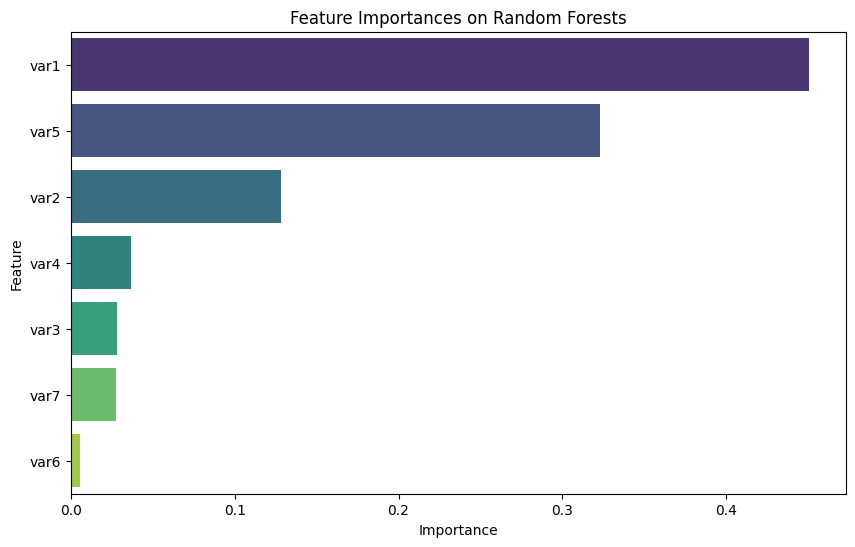

In [75]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Feature', dodge=False, palette='viridis')
plt.title('Feature Importances on Random Forests')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#### Tree Visualization

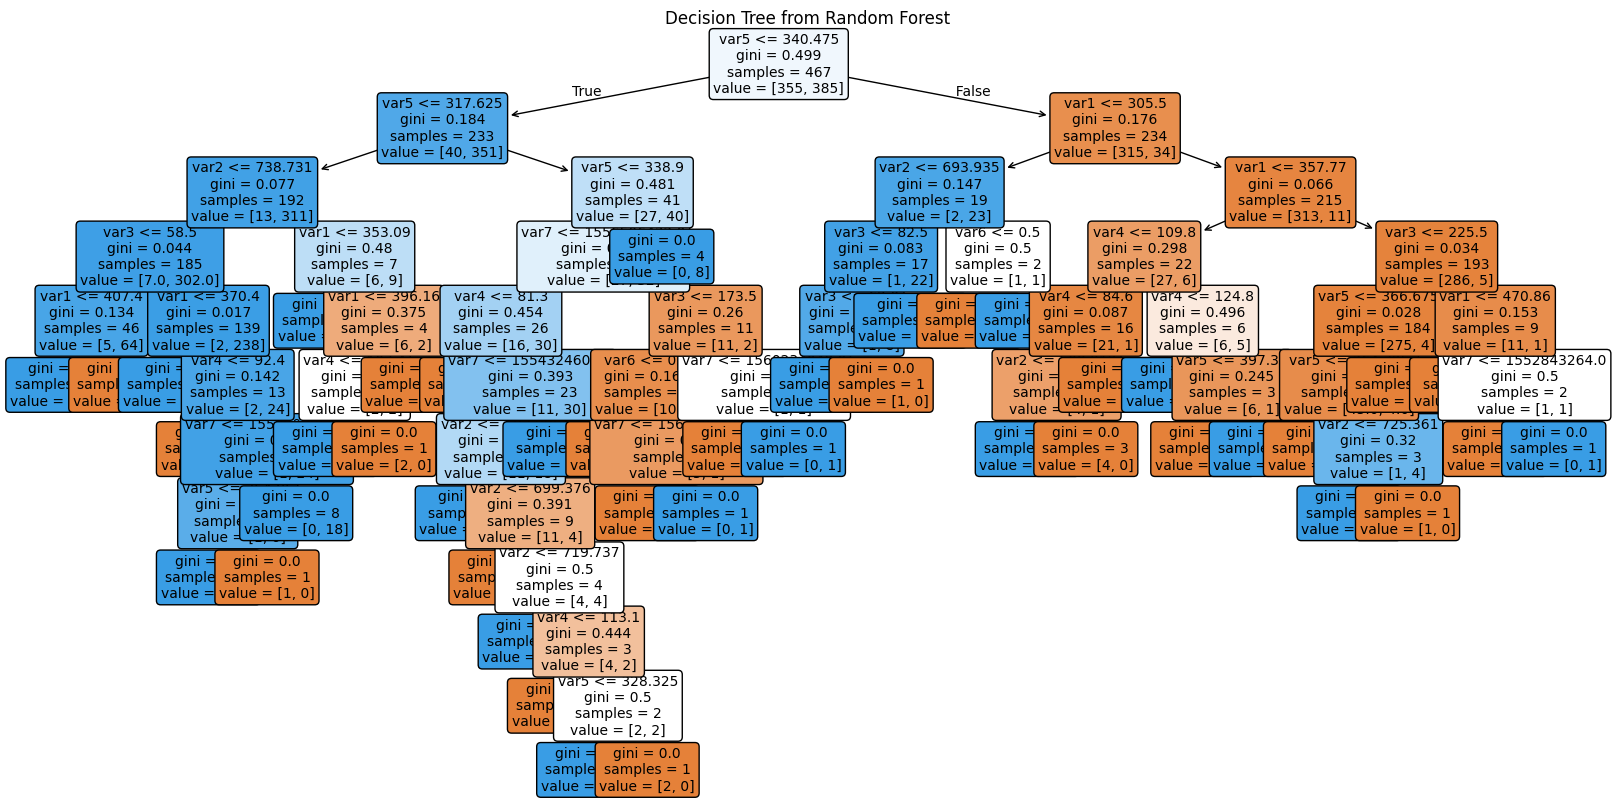

In [76]:
# Get feature names
feature_names = X.columns

# Visualize one of the trees in the forest
plt.figure(figsize=(20, 10))
plot_tree(rf_classifier.estimators_[0], feature_names=feature_names, filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree from Random Forest')
plt.show()

Limited Depth

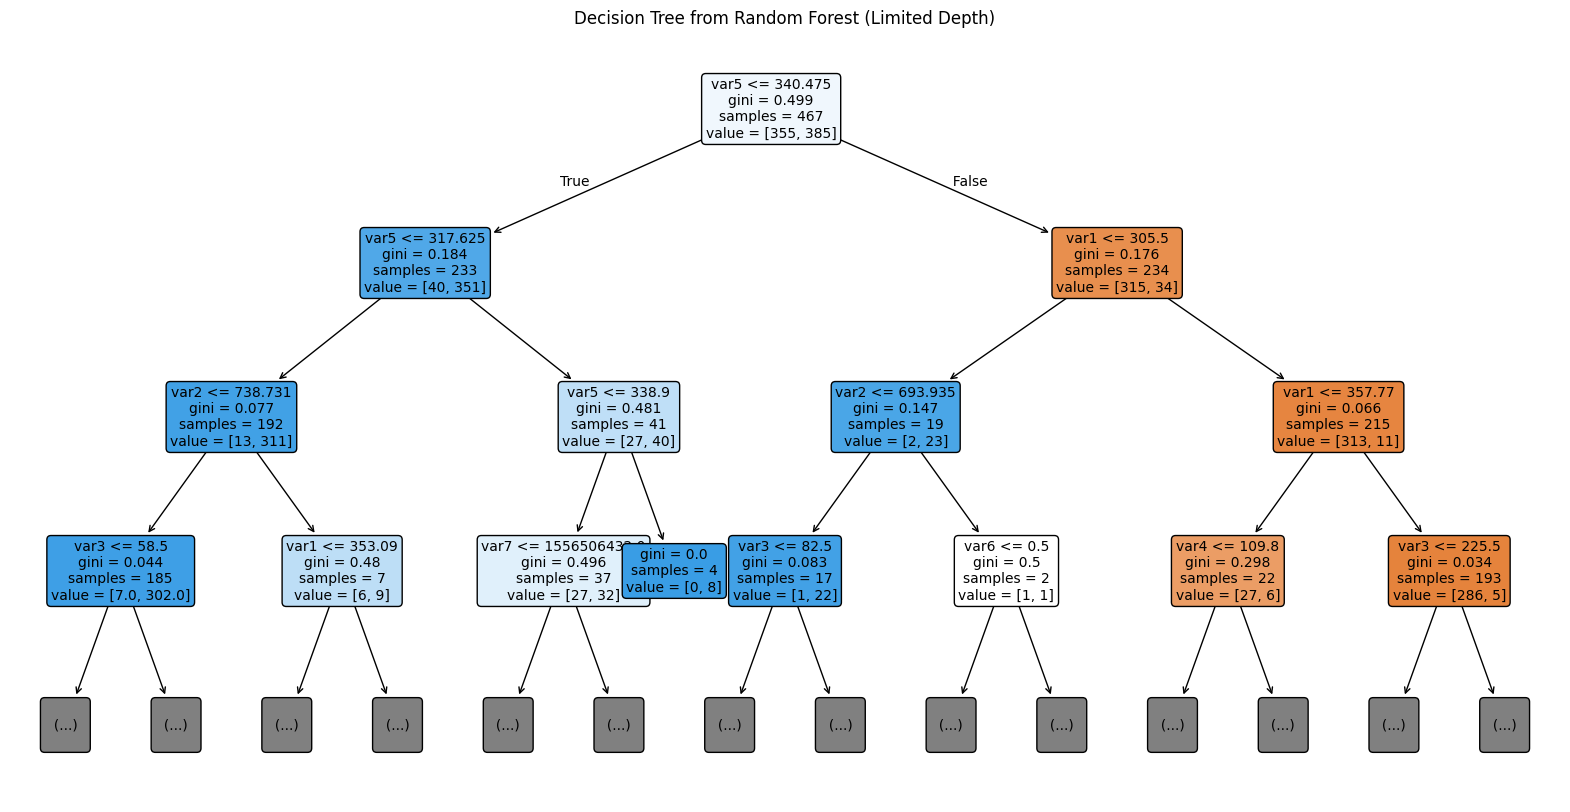

In [77]:
# Visualize one of the trees in the forest with limited depth
plt.figure(figsize=(20, 10))
plot_tree(rf_classifier.estimators_[0], feature_names=feature_names, filled=True, rounded=True, fontsize=10, max_depth=3)
plt.title('Decision Tree from Random Forest (Limited Depth)')
plt.show()

#### Partial Dependence Plots (PDP)

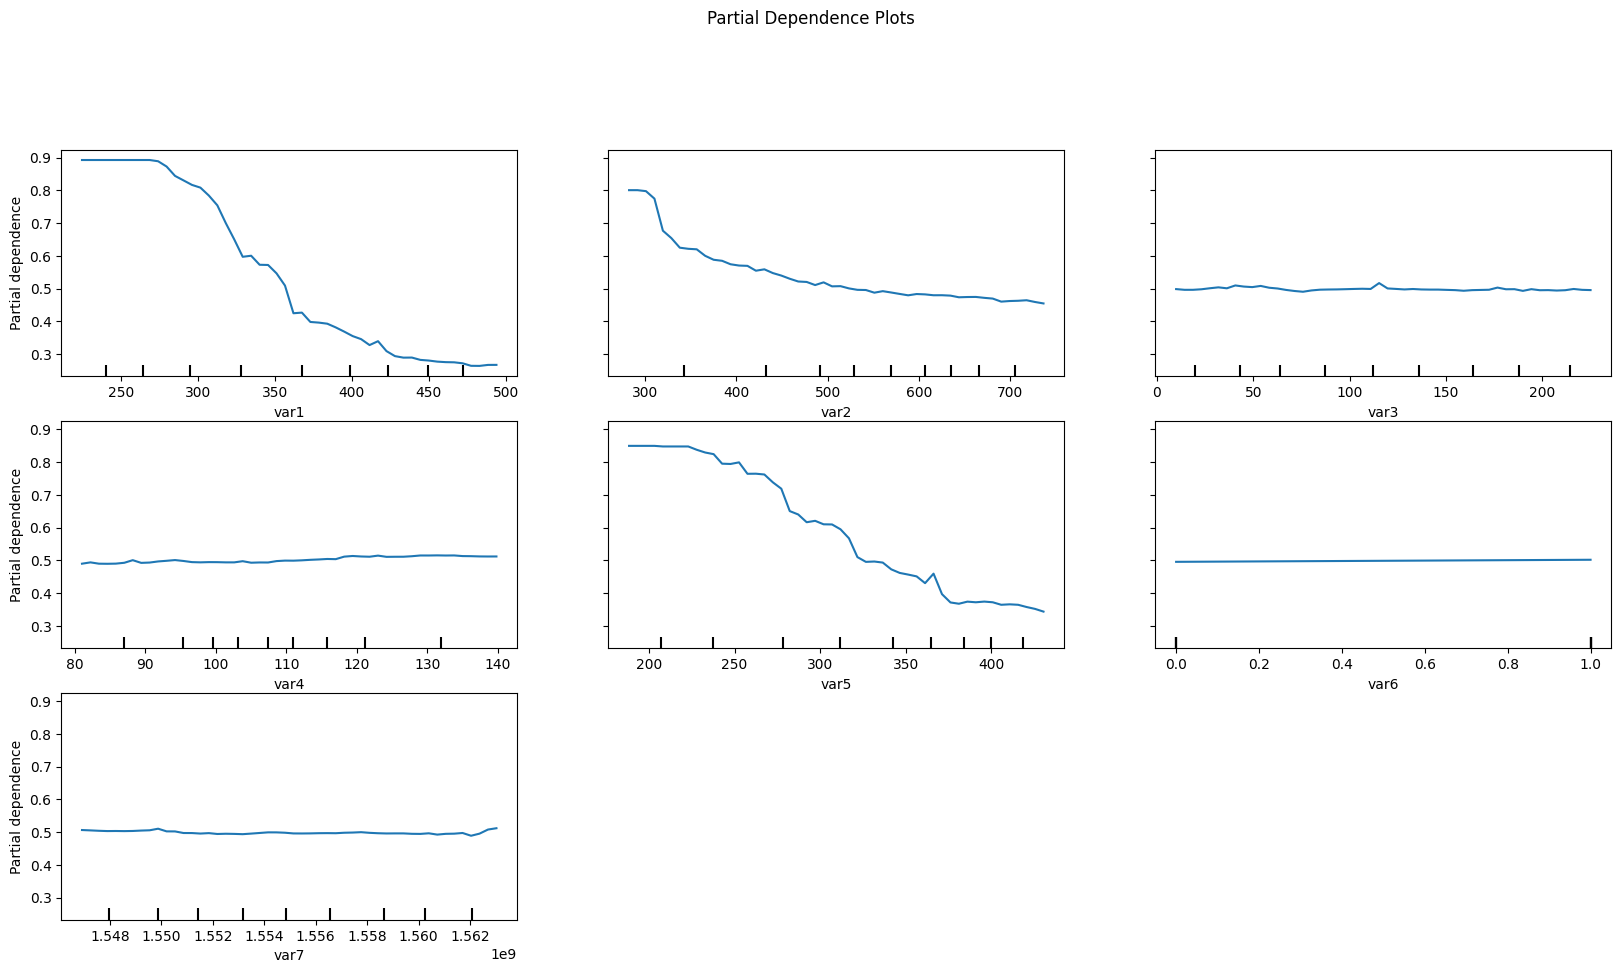

In [78]:
# Create Partial Dependence Display
fig, ax = plt.subplots(figsize=(20, 10))
display = PartialDependenceDisplay.from_estimator(rf_classifier, X, feature_names, feature_names=feature_names, grid_resolution=50, ax=ax)
plt.suptitle('Partial Dependence Plots', y=1.02)
plt.show()